### Student Details

**Student name:** Muhammad Khubaib Akram

**Student ID:** 23098929

# Description

In this task, we will use NSL-KDD dataset. We will use the NSL-KDD dataset to do multi-class classification. This dataset is quite large, and the training time can be quite long if you use the whole thing so that we will use just 20% of the dataset. If you completed the network security task in the previous activity (i.e., if you are in the BSc in CyberSecurity), you will have seen this already. For those that have not seen this dataset before, you will also be dealing with many more dimensions than you have done up to now, but you will see that the machine learning techniques we have employed up to now scale nicely to many dimensions.

The aim of the NSL-KDD dataset is to enable training a machine learning algorithm to identify different types of cyber attacks based on network trafiic features. The different attacks can be: denial-of-service (dos), Remote to user (r2l), probing attack (probe), User-to-Root (U2R). I hope this means something to the CyberSecurity cohort. For the rest of us, don't worry, we can just see it as a generic classification task.

The data is already split into training and testing. It also contains a mix of different types of features - categorical, binary, and numerical features. However, in this task, we are going to investigate only the numerical features. So, in the code just below, I have stripped out all of the non-numerical features, and provide you with the numpy arrays `train_X`, `train_Y`, `test_X`, and `test_Y`.

Our aim will be to use the available data to train an algorithm to predict the type of attack that is occurring. We will then see if we can get similar performance by using fewer features. Undoubtedly, unless there is a feature that has no influence *at all* on the output, we will see *some* degradation in performance. However, as discussed in the material, there are significant gains to be made by using fewer features.

In [2]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
####################
# CODE PROVIDED

# This code is a little bit complicated, and I don't want you to get bogged down in reading from csv files.
# This code reads from the CSV files, and creates the training and test sets for both binary and multi-class

# Read the data
import pandas as pd
test_df = pd.read_csv('https://raw.githubusercontent.com/Khubaibakramshirani/Khubaibakramshirani/main/KDDTest_CE4317.csv', header=0)
train_df = pd.read_csv('https://raw.githubusercontent.com/Khubaibakramshirani/Khubaibakramshirani/main/KDDTrain_CE4317.csv', header=0)

# Differentiating between nominal, binary, and numeric features
# Note, we only need to do this for the train data, as the train and test have the same feature names (of course)
col_names = train_df.columns.values

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 19, 20]
numeric_idx = list(set(range(40)).difference(nominal_idx).difference(binary_idx))

numeric_cols = col_names[numeric_idx].tolist()   # The columns that have numerical features

train_Y = train_df['attack_category']
test_Y = test_df['attack_category']

# In this case, we are only going to use the numeric columns for our predictions
train_X = train_df[numeric_cols]
test_X = test_df[numeric_cols]

print(train_X.shape)
print(test_X.shape)

(25192, 31)
(22544, 31)


Let's have a quick look at what some of the samples look like

In [4]:
# Let's look at the data
train_X

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,491,0,0,0,0,0,0,0,0,...,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0,146,0,0,0,0,0,0,0,0,...,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0,0,0,0,0,0,0,0,0,0,...,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0,232,8153,0,0,0,0,0,0,0,...,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0,199,420,0,0,0,0,0,0,0,...,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,0,0,0,0,0,0,0,0,0,0,...,255,7,0.03,0.06,0.00,0.00,0.00,0.00,1.00,1.00
25188,0,334,0,0,0,0,0,0,0,0,...,1,39,1.00,0.00,1.00,0.18,0.00,0.00,0.00,0.00
25189,0,0,0,0,0,0,0,0,0,0,...,255,13,0.05,0.07,0.00,0.00,0.00,0.00,1.00,1.00
25190,0,0,0,0,0,0,0,0,0,0,...,255,20,0.08,0.06,0.00,0.00,1.00,1.00,0.00,0.00


And let's look quickly at how many samples in each attack category we have

In [5]:
train_df['attack_category'].unique()

array(['benign', 'dos', 'r2l', 'probe', 'u2r'], dtype=object)

Text(0, 0.5, 'Attack category')

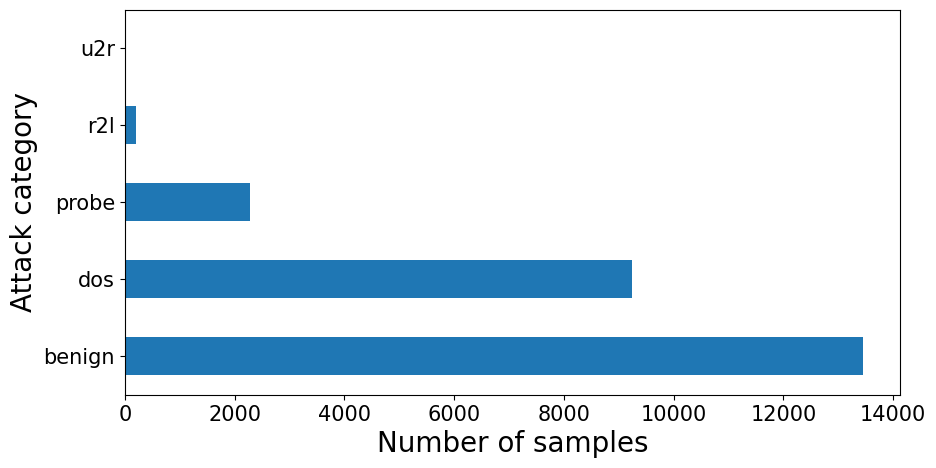

In [6]:
import matplotlib.pyplot as plt

train_attack_cats = train_df['attack_category'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()
train_attack_cats.plot(kind='barh', figsize=(10,5), fontsize=15)
plt.xlabel("Number of samples", fontsize=20)
plt.ylabel("Attack category", fontsize=20)

# Task 1- Feature Selection

### Part 1: Support Vector Classification

Here, we will use Support Vector Classification to predict the type of network attack that is occurriing, given a set of features. We will use a simple linear SVM Classification, and use the default parameters, as we're not investigating the properties of SVM, but rather the properties of data.

#### Task:
1. Apply the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to the training and test data. Remember, train on the `*_train` data, but apply to both the `*_train` and the `*_test` data
1. Train a linear Support Vector Classification, using [`sklearn`'s `svm.SVC` class](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). All parameters can be left at default except `kernel='linear'`
1. Predict the category of the network attack
1. Print the [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and the [accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
1. Discuss the confusion matrix briefly

You should see that the linear SVM Classification isn't too bad. You should get an accuracy around 0.73


<span style="color:red">Insert your code below</span>.

In [7]:


####################################
# Your code here
# Step 1: Apply StandardScaler to the training and test data
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)



In [8]:
####################
# YOUR CODE

# 2 - Train a linear Support Vector Classification (SVC)
svc = SVC(kernel='linear')
svc.fit(train_X_scaled, train_Y)

# 3 - Predict the category of the network attack
predicted_Y = svc.predict(test_X_scaled)

#4 - Print the confusion matrix and the accuracy score
confusion = confusion_matrix(test_Y, predicted_Y)
accuracy = accuracy_score(test_Y, predicted_Y)

print("Confusion Matrix:")
print(confusion)
print()
print("Accuracy Score:", accuracy)

# Step 5: Discuss the confusion matrix briefly


Confusion Matrix:
[[9085  472  150    4    0]
 [2100 5521   15    0    0]
 [ 431  128 1864    0    0]
 [2544    5   23    2    0]
 [ 156    0   38    1    5]]

Accuracy Score: 0.7308818310858765


<span style="color:red">Insert your text answers below</span>.

 The confusion matrix will shows the true positive, true negative, false positive, and false negative values for the predictions.
 These values can be interpreted as follows:

 - True Positive (TP):  TP represents the cases where the actual value and predicted value are the same for a given class. In this matrix, the diagonal values represent TP for each class.

 For example, benign', 'dos', 'r2l', 'probe', 'u2r'

  * In the top-left cell (9085), it represents TP for Attack Category 1 (benign).
  * In the second cell on the diagonal (5521), it represents TP for Attack Category 2 (dos).
  * In the third cell on the diagonal (1864), it represents TP for Attack Category 3 (r2l).
  * In the fourth cell on the diagonal (2), it represents TP for Attack Category 4 (probe).  
  * In the fifth cell on the diagonal (5), it represents TP for Attack Category 5 (u2r)

 - True Negative (TN): The number of correctly predicted negative instances (correctly classified non-attacks).

 for example:

    * Sum of all values except those in the 1st row and 1st column (i.e., all other instances correctly predicted as not Attack Category 1).
    (5521 + 15 +0+0+ 128 + 1864 +0+0+ 5 + 23 + 2 +0+ +0+38 + 1 + 5) = 7602
    * Sum of all values except those in the 2nd row and 2nd column (i.e., all other instances correctly predicted as not Attack Category 2).
    TN for Attack Category 2 = 14303

    * Sum of all values except those in the 3rd row and 3rd column (i.e., all other instances correctly predicted as not Attack Category 3).
    TN for Attack Category 3 = 19895
    *  Sum of all values except those in the 4th row and 4th column (i.e., all other instances correctly predicted as not Attack Category 4).
    TN for Attack Category 4 = 19965
    *  Sum of all values except those in the 5th row and 5th column (i.e., all other instances correctly predicted as not Attack Category 5).
    TN for Attack Category 5 = 22,344



 - False Positive (FP): FP represents the cases where the model predicted the class but the actual class was different.
 For each class, the FP value is the sum of the values in the corresponding column (excluding the TP value in the diagonal).

 For example,

  * In the first (2100 + 431 + 2544 + 156)= 5231 , it represents FP for Attack Category 1.
  * In the second (472 + 128 + 5 + 0) = 605, it represents FP for Attack Category 2.
  * In the third (150 + 15 + 23 + 38) = 226, it represents FP for Attack Category 3.
  * In the fourth (4 + 0 + 0 + 1) = 5, it represents FP for Attack Category 4.
  * In the fifth column (0 + 0 + 0 + 0) =0, it represents FP for Attack Category 5.

 - False Negative (FN): The number of actual positive instances incorrectly predicted as negative (attacks classified as non-attacks).The False-negative value for a class will be the sum of values of corresponding rows except for the TP value.

  For example,

  * In the first row (472+ 150 + 4 + 0) = 626, it represents FN for Attack Category 1
  * In the second row (2100+ 15+0+0) = 2115, it represents FN for Attack Category 2
  * In the third row (431+ 128 + 0 + 0) = 559, it represents FN for Attack Category 3
  * In the fourth row (2544+ 5 + 23 + 0) = 2572, it represents FN for Attack Category 4
  * In the fifth row (156+ 0 + 38 + 1) = 195, it represents FN for Attack Category 5



### Part 2: Feature Variance

Feature variance is a rather simple way of predicting if a given feature will have influence on the outcome of a trained model. The principle is that, if a feature has low variance, it cannot have much influence on the model prediction. As an extreme, if we have a variance of 0 in a feature across all samples, i.e. we have the same value for this feature in all samples, then this feature cannot be used to distinguish samples and is useless as a predictor.

However, the converse is not true. A high variance in a feature does not necessarily mean that it is a good predictor. You could imagine a feature that just contains noise with high amplitude. It might have high variance, but is meaningless. Or you can have a feature that has high variance but no influence on the outcome. For example, would hair length in cm have any influence on a baseball players salary? That said, variance can be a useful measure of the strength of a predictor.

The variance of a set of features is given by:

$$
S_{i}^{2} = \frac{\sum_{j=1}^n\left(\textbf{X}_{i,j} - \overline{\textbf{X}}_i \right)^2}{n - 1}
$$

where $\textbf{X}_{i,j}$ is the $j$'th sample of the $i$'th feature, $\overline{\textbf{X}}_i$ is the mean of all the samples of the $i$'th feature, and $n$ is the total number of samples.

Variance thresholding doesn't examine the relationship between the feature $\textbf{X}$ and the output $\textbf{y}$. This has the disadvantage that you can't test if the feature actually has an influence on the output. However, even though in this case we use it in a supervised learning context, it does mean that we can use variance thresholding for unsupervised learning.

#### Notes:
1. In Part 1, we used the `StandardScaler` to scale the features. In general, this is good practice, and in the next Task where we look at PCAs, really is even required. The `StandardScaler` will make it so every feature has a variance of 1 (unless the features started out with a variance of 0 to begin with) and a mean of 0. Therefore, features scaled with `StandardScaler` are useless for thresholding on variance, as there is no practical way to distinguish them.
2. However, we should not do `VarianceThreshold`ing on just the raw data. Have a look at the values in the training dataset. Some columns will have typically small values. It is the nature of that data, and even though they may have a large influence on the type of attack, they will have a lower variance compared to some of the other columns.
3. So we must scale, but not using the `StandardScaler`. Here it is more appropriate to use the [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), which scales all the data to the range 0 to 1 by default (though you can set any range).
4. Note that `MinMaxScaler` can also be applied to machine learning algorithms. Just in this case, we want to use the `StandardScaler`. There is, in fact, a [whole suite of other scalers provided by scikit-learn](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html). Each has it's own benefits. In fact, some would say we should use `MinMaxScaler` as the default scaler, and only use `StandardScaler` if we know the distribution of the data is normal.

#### Task:
1. Fit an instance of the `MinMaxScaler` with the original `X_train` data. You will get a set of data in the range 0 to 1.
2. It is not very intuitive what threshold of variance we should use. So it's better to plot the variances of each feature, and then decide if some of the variances are small enough to discard
3. Use `np.var` function to calculate the variances of the features (`axis-0`). Plot the variances, and pick a value that might remove 3 or 4 of the features.
4. Fit the output of the `MinMaxScaler` using an object of [`sklearn.feature_selection`'s `VarianceThreshold` class](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) using this threshold
5. `transform` the data that was scaled with the `StandardScaler`. This is an important step. Notice that we use the output of the `MinMaxScaler` to select the features, but the data we want to use is selected from the `StandardScaler`.
6. Repeat the steps of Part 1: Train an SVC with the selected features and print the accuracy.
7. How does the accuracy compare to the the SVC with no features removed (from Part 1)?

<span style="color:red">Insert your code below</span>.

Train_X with Min Max Scalar:  (25192, 31)
----------------------------------------------------------------------
train_X_minMaxScaler :
 [[0.00000000e+00 1.28631990e-06 0.00000000e+00 ... 0.00000000e+00
  5.00000000e-02 0.00000000e+00]
 [0.00000000e+00 3.82490236e-07 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]]
----------------------------------------------------------------------
feature_variances :
 [3.92852549e-03 3.98879822e-05 2.97345308e-04 7.52357388e-03
 3.96935656e-05 7.82661671e-04 1.28920576e-04 1.38865036e-04
 1.39133845e-04 1.75292164e-04 3.57128640e-04 1.5

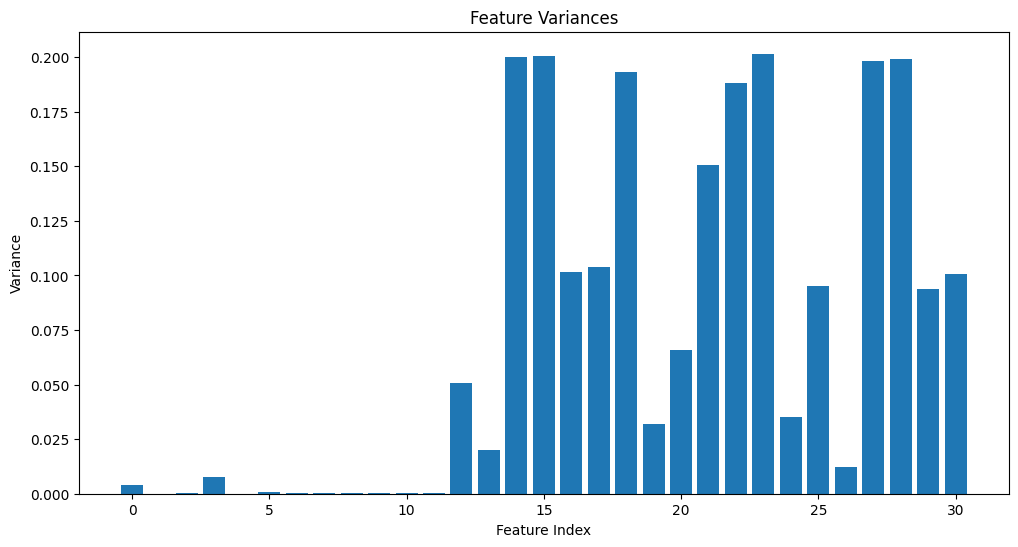

In [9]:
#1 - Fit an instance of the MinMaxScaler with the original X_train data.
miMxScaler = MinMaxScaler()
train_X_minMaxScaler = miMxScaler.fit_transform(train_X)
print("Train_X with Min Max Scalar: ", train_X_minMaxScaler.shape)
print("-" * 70)
print(f"train_X_minMaxScaler :\n {train_X_minMaxScaler}")
print("-" * 70)



#2- plot the variances of each feature. Use np.var function to calculate the variances of the features (axis-0). Plot the variances, and pick a value that might remove 3 or 4 of the features.
feature_variances = np.var(train_X_minMaxScaler, axis=0)
print(f"feature_variances :\n {feature_variances}")
print("-" * 70)

print(f"feature_variances sort:\n {np.sort(feature_variances)}")

print("-" * 70)
print(f"feature_variances Shape: {feature_variances.shape}")
print("-" * 70)


plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_variances)), feature_variances)
plt.xlabel('Feature Index')
plt.ylabel('Variance')
plt.title('Feature Variances')
plt.show()


#3- Fit the output of the MinMaxScaler using an object of sklearn.feature_selection's VarianceThreshold class using this threshold
variance_threshold = VarianceThreshold(threshold=0.01)
X_train_variance_threshold = variance_threshold.fit_transform(train_X_minMaxScaler)


X_test_scaled = scaler.transform(test_X)
X_test_selected = X_test_scaled[:, variance_threshold.get_support()]



In [10]:
svc_selected = SVC(kernel='linear')
#svc_selected.fit(X_train__Variance_Scaled, train_Y)
svc_selected.fit(X_train_variance_threshold, train_Y)
predicted_Y_selected = svc_selected.predict(X_test_selected)

accuracy_selected = accuracy_score(test_Y, predicted_Y_selected)
print("Accuracy with feature selection:", accuracy_selected)

Accuracy with feature selection: 0.6575141944641589


<span style="color:red">Insert your text answers below</span>.

**How does the accuracy compare to the the SVC with no features removed (from Part 1)?**

  **Accuracy with feature selection:** 0.6575141944641589 is lower as compared to the **Accuracy Score with No features removed:** 0.7308818310858765.

  Feature selection involves reducing the number of features, potentially discarding those that were deemed less informative or relevant.

  Removing certain features using feature selection led to a reduction in accuracy. This suggests that the removed features contained useful information for the classification task


### Part 3: Univariate Feature Selection - `f_classif`

Univariate feature selection works by performing statistical tests on each of the features (i.e. on each column in our dataset). There are a [few options provided by `scikit-learn`](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection). We will use the [`SelectKBest` functionality](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html), which allows us to pick "the top" `K` features per the metric we select. To pick the top features, we will use the [`f_classif` function](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html), as we are doing a classification. `f_classif` uses the ANOVA F-value to determine features to select. More info on ANOVA is available [here](https://datascience.stackexchange.com/questions/74465/how-to-understand-anova-f-for-feature-selection-in-python-sklearn-selectkbest-w).

The `SelectKBest` functionality coupled with `f_classif`, will use this score to pick the `K` top features.

#### Task:
1. Loop over the total count of features (i.e. for variable `k` from 1 to 31)
2. Use the [`SelectKBest` class](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) with [`f_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html) to pick the top `k` features from our dataset
3. Train a new SVM classification with features transformed with the `SelectKBest` object you just created (note: both train and test data have to be transformed)
4. Use the `accuracy_score` function to get the accuracy at each iteration
5. Repeat steps 2 to 4 for each value of `k`.
6. Then plot the accuracy versus number of features in a single plot
7. Given this data, discuss the number of features you might use in a final solution? (Use markdown - no wrong answer here)
8. How doe the "best" accuracy value compare with the SVM before removing any features?

this will take a few minutes to run, go get a coffee!

<span style="color:red">Insert your code below</span>.

In [11]:
#To suppress the warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

#Import the necessary libraries
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

NOTE WITHOUT SCALED VALUES IT WAS TAKING TOO MUCH TIME. I got below values only with after 2.5 hours.

1. 0.6254435770049681
2. 0.6338271823988645
3. 0.6298349893541518
4. 0.6325851667849539
5. 0.6300124201561391
6. 0.6300124201561391
7. 0.6390613910574876
8. 0.6266855926188787
9. 0.6470014194464159
10. 0.6775195173882186


So, After talking to professor in the tutorial on Tuesday 31st of OCT. I am scalling the data


In [12]:
scalar = StandardScaler()
train_X_Scaled = scalar.fit_transform(train_X)
test_X_Scaled = scalar.transform(test_X)  # Scale the test data using the same scaler

print("Train_X_Scaled shape:", train_X_Scaled.shape)
print("Test_X_Scaled shape:", test_X_Scaled.shape)


####################################
# Your code here

feature_counts = list(range(1, 32))
accuracies = []
#Loop over the total count of features (i.e. for variable k from 1 to 31)
for k in feature_counts:
    # Select the top k features using SelectKBest and f_classif
    selectorKB = SelectKBest(score_func=f_classif, k=k)
    X_train_selectedKB = selectorKB.fit_transform(train_X_Scaled, train_Y)
    X_test_selectedKB = selectorKB.transform(test_X_Scaled)

    # Train an SVM with the selected features and calculate accuracy
    svc_selected = SVC(kernel='linear')
    svc_selected.fit(X_train_selectedKB, train_Y)
    predicted_Y_selected = svc_selected.predict(X_test_selectedKB)

    #Use the accuracy_score function to get the accuracy at each iteration
    accuracy_selected = accuracy_score(test_Y, predicted_Y_selected)
    accuracies.append(accuracy_selected)
    print(f"With K={k}  features  is : '{accuracy_selected}'")

Train_X_Scaled shape: (25192, 31)
Test_X_Scaled shape: (22544, 31)
With K=1  features  is : '0.6254435770049681'
With K=2  features  is : '0.6342264017033357'
With K=3  features  is : '0.6298793470546487'
With K=4  features  is : '0.6325851667849539'
With K=5  features  is : '0.6297906316536551'
With K=6  features  is : '0.6297906316536551'
With K=7  features  is : '0.632319020581973'
With K=8  features  is : '0.631165720369056'
With K=9  features  is : '0.6521025550035486'
With K=10  features  is : '0.6780518097941802'
With K=11  features  is : '0.6865684882895671'
With K=12  features  is : '0.6893630234208659'
With K=13  features  is : '0.7053317955997161'
With K=14  features  is : '0.7051543647977289'
With K=15  features  is : '0.7051543647977289'
With K=16  features  is : '0.7164655784244145'
With K=17  features  is : '0.7105660042583393'
With K=18  features  is : '0.7296841731724627'
With K=19  features  is : '0.7294180269694819'
With K=20  features  is : '0.7299059616749468'
With

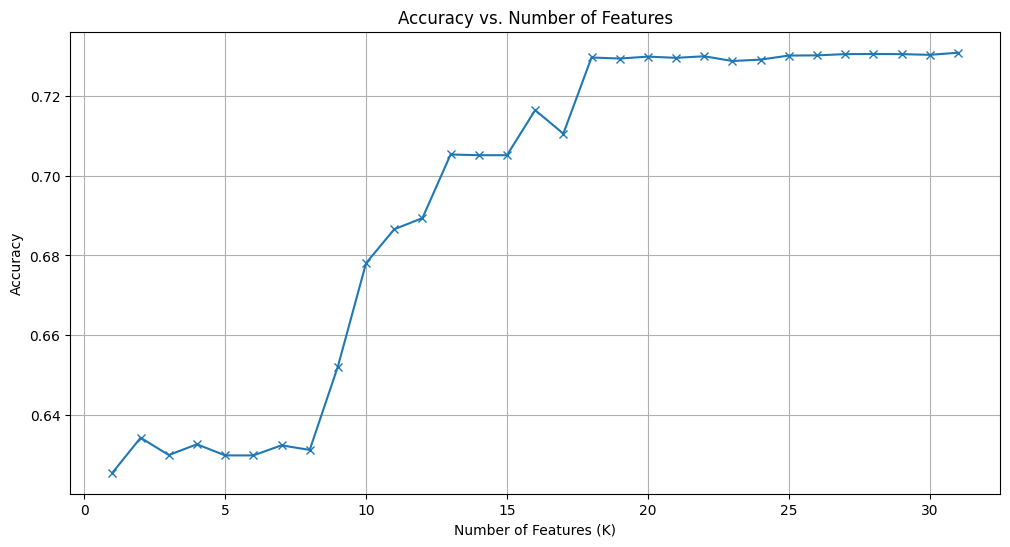

In [13]:
import matplotlib.pyplot as plt

####################################
# Your code here
plt.figure(figsize=(12, 6))
plt.plot(feature_counts, accuracies, marker='x')
plt.title('Accuracy vs. Number of Features')
plt.xlabel('Number of Features (K)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

<span style="color:red">Insert your question answers below</span>.

**How does the "best" accuracy value compare with the SVM before removing any features?**

  The accuracy of the SVM model before and after feature selection is the same, with the best accuracy value achieved with feature selection (K-best feature selection where K was 31) being 0.7308818310858765. This means that with the appropriate selection of K features, we can achieve the same accuracy as the model without feature selection.




# Task 2: Dimensionality Reduction via PCA

PCA is one of the most commonly used unsupervised transforms, and one of the most commmon means to manipulate data for machine learning. You touched on the PCA in E-tivity 2, where we investigated linear algebra. Here we will use it to reduce the numbers of features needed for a machine learning algorithm.

In the last task, we removed features. The first part, we just used some statistics on the features themselves, in independence of the other features and of the output. Then, we looked at the correlation between features and the output.

What PCA does is look at correlations *between features*. If we have high correlation between two or more features, PCA will find vectors in the feature space that best describe all features. It doesn't remove features, rather it creates a new feature space, and projects all samples to this feature space. The basis of the new feature space is a linear combination of the original features. Maybe a bit crudely, you can think of it as combining features.

Let's look at an example. Here is the first few rows of the dataset.

In [14]:
train_df.head(8)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_category,attack_binary
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,benign,0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,benign,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,dos,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,benign,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,benign,0
5,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,dos,1
6,0,tcp,private,S0,0,0,0,0,0,0,...,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,dos,1
7,0,tcp,private,S0,0,0,0,0,0,0,...,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,dos,1


Ok, so in a small handfull of features, we can spot that (perhaps) `num_root` and `num_compromised` are correlated? Let's plot a few of them that might be correlated.

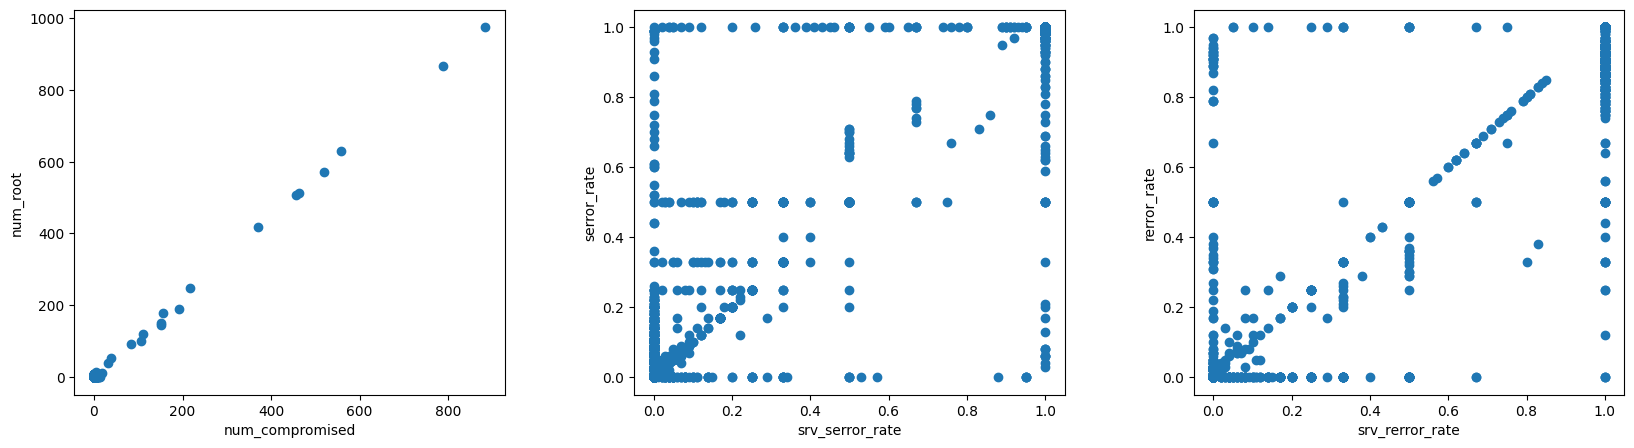

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.subplots_adjust(wspace=0.3)

ax[0].scatter(train_df['num_compromised'], train_df['num_root']);
ax[0].set(xlabel='num_compromised', ylabel='num_root')

ax[1].scatter(train_df['srv_serror_rate'], train_df['serror_rate']);
ax[1].set(xlabel='srv_serror_rate', ylabel='serror_rate')

ax[2].scatter(train_df['srv_rerror_rate'], train_df['rerror_rate']);
ax[2].set(xlabel='srv_rerror_rate', ylabel='rerror_rate')

plt.show()

Note that the last two plots, while there are outliers in the plots (values at 1.0), most of the data lies along the diagonal. Just the drawing doesn't show this well, though it is highly correlated.

Yes, we can see that there is some correlation between the features we selected here. We can probably assume that there is a causal relationship between them - CyberSecurity specialists wish to comment?

So there is certainly some redundancy here. And likely there are more hidden correlations that we don't know about!

# Task

On to this weeks task. We will perform PCA on the data, before training a linear SVM, and explore some more properties of it, and how it affects the machine learning algorithm.

1. Run [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on the standard scaled data. Initially, set the desired variance to keep to 95% (`n_components=0.95`, all other parameters set to default)
2. Train a Support Vector Classification on the PCA reduced data. As with Task 1, use a linear SVM and keep all other parameters as default
3. Try 99% and 90%
4. Play around with desired variance to see if you can reduce the number of features while maintaining an accuracy close to the original dataset above

Discuss the following points, and compare with the previous task in this e-tivity:

1. How many new features are there after the PCA?
2. Discuss the "goodness" of the model, compared with the one without scaling (from Task 1), by comparing the accuracy
3. How about if we set the variance to 99%? And how about 99.9%?
4. Can you get better accuracy with fewer features using PCA compared to dropping the features from Task 1?

Note that the parameter `n_components` of `PCA` can take either a real value between 0 and 1, in which case it will pick the number of components that maintains that level of variance in the samples, or it can take an integer value, in which case it will keep that number of components.

<span style="color:red">Insert your code below</span>.

In [16]:
from sklearn.decomposition import PCA


1. Run PCA on the standard scaled data. Initially, set the desired variance to keep to 95% (n_components=0.95, all other parameters set to default)

In [17]:
# Scalling the data both training and testing
pca_scalar = StandardScaler()
train_X_Scaled_for_pca = pca_scalar.fit_transform(train_X)
test_X_Scaled_for_pca = pca_scalar.transform(test_X)  # Scale the test data using the same scaler

print("Train_X_Scaled shape:", train_X_Scaled_for_pca.shape)
print("Test_X_Scaled shape:", test_X_Scaled_for_pca.shape)

Train_X_Scaled shape: (25192, 31)
Test_X_Scaled shape: (22544, 31)


In [18]:
####################################
# Your code here



# Initialize PCA with the desired variance explained (0.95 for 95% variance)
pca_95 = PCA(n_components=0.95)

# Fit and transform the data to the reduced feature space
X_train_pca_95 = pca_95.fit_transform(train_X_Scaled_for_pca)
X_test_pca_95 = pca_95.transform(test_X_Scaled_for_pca)

2. Train a Support Vector Classification on the PCA reduced data. As with Task 1, use a linear SVM and keep all other parameters as default

In [19]:
####################################
# Your code here
# Train an SVC with the reduced feature space
svc_pca = SVC(kernel='linear')
svc_pca.fit(X_train_pca_95, train_Y)

#Make a prediction on the test data
predicted_Y_pca_95 = svc_pca.predict(X_test_pca_95)
accuracy_pca_95 = accuracy_score(test_Y, predicted_Y_pca_95)
print(accuracy_pca_95)

print(f"num_features_retained = {pca_95.n_components_}%")
print(f"Number of Features (Principal Components): {X_train_pca_95.shape[1]}")
print(f"Accuracy with PCA: {accuracy_pca_95}")

0.7278655074520937
num_features_retained = 19%
Number of Features (Principal Components): 19
Accuracy with PCA: 0.7278655074520937


3. Try 99% and 90%

In [20]:
####################################
# Your code here

# Keep 99% of the variance
pca_99 = PCA(n_components=0.99)
X_train_pca_99 = pca_99.fit_transform(train_X_Scaled_for_pca)
X_test_pca_99 = pca_99.transform(test_X_Scaled_for_pca)

# Train an SVC with the reduced feature space with PCA which 99% of the variance
svc_pca_99 = SVC(kernel='linear')
svc_pca_99.fit(X_train_pca_99, train_Y)

#Make a prediction on the test data
predicted_Y_pca_99 = svc_pca_99.predict(X_test_pca_99)
accuracy_pca_99 = accuracy_score(test_Y, predicted_Y_pca_99)

print(f"num_features_retained = {pca_99.n_components_}%")
print(f"Number of Features (Principal Components): {X_train_pca_99.shape[1]}")
print(f"Accuracy with PCA: {accuracy_pca_99}")

num_features_retained = 23%
Number of Features (Principal Components): 23
Accuracy with PCA: 0.7301721078779276


In [21]:
####################################
# Your code here

# Keep 90% of the variance
pca_90 = PCA(n_components=0.90)
X_train_pca_90 = pca_90.fit_transform(train_X_Scaled_for_pca)
X_test_pca_90 = pca_90.transform(test_X_Scaled_for_pca)

# Train an SVC with the reduced feature space with PCA which 90% of the variance
svc_pca_90 = SVC(kernel='linear')
svc_pca_90.fit(X_train_pca_90, train_Y)

#Make a prediction on the test data
predicted_Y_pca_90 = svc_pca_90.predict(X_test_pca_90)
accuracy_pca_90 = accuracy_score(test_Y, predicted_Y_pca_90)
print(f"num_features_retained = {pca_90.n_components_}%")
print(f"Number of Features (Principal Components): {X_train_pca_90.shape[1]}")
print(f"Accuracy with PCA: {accuracy_pca_90}")

num_features_retained = 16%
Number of Features (Principal Components): 16
Accuracy with PCA: 0.7263129879347054


4. Play around with desired variance to see if you can reduce the number of features while maintaining an accuracy close to the original dataset above

In [22]:
# Set the desired variances
variance_ratios = [0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 0.999]

for desired_variance in variance_ratios:
    # Initialize PCA with the desired variance
    pca = PCA(n_components=desired_variance)

    # Fit and transform the training data
    X_train_pca = pca.fit_transform(train_X_Scaled)

    # Transform the test data
    X_test_pca = pca.transform(test_X_Scaled)

    # Train a linear Support Vector Classification
    svc_pca = SVC(kernel='linear')
    svc_pca.fit(X_train_pca, train_Y)

    # Make predictions on the test data
    predicted_Y_pca = svc_pca.predict(X_test_pca)

    # Calculate accuracy
    accuracy_pca = accuracy_score(test_Y, predicted_Y_pca)

    # Print results
    print(f"Desired Variance: {desired_variance * 100}%")
    print(f"Number of Features (Principal Components): {X_train_pca.shape[1]}")
    print(f"Accuracy with PCA: {accuracy_pca}")
    print("-" * 50)

Desired Variance: 60.0%
Number of Features (Principal Components): 6
Accuracy with PCA: 0.718417317246274
--------------------------------------------------
Desired Variance: 70.0%
Number of Features (Principal Components): 9
Accuracy with PCA: 0.7177075940383251
--------------------------------------------------
Desired Variance: 80.0%
Number of Features (Principal Components): 12
Accuracy with PCA: 0.7184616749467707
--------------------------------------------------
Desired Variance: 90.0%
Number of Features (Principal Components): 16
Accuracy with PCA: 0.7263129879347054
--------------------------------------------------
Desired Variance: 95.0%
Number of Features (Principal Components): 19
Accuracy with PCA: 0.7278655074520937
--------------------------------------------------
Desired Variance: 99.0%
Number of Features (Principal Components): 23
Accuracy with PCA: 0.7301721078779276
--------------------------------------------------
Desired Variance: 99.9%
Number of Features (Princ

<span style="color:red">Insert your text answers below</span>.



1.   **How many new features are there after PCA?**

      The number of new features after PCA depends on the desired variance PCA(n_components=desired_variance).

      If you set the desired variance to 60%, PCA will retain as many principal components as needed to explain 60% of the total variance in the data.
      As per my exploration it retained "Number of Features (Principal Components): 6"
      
      If you set the desired variance to 70%, PCA will retain as many principal components as needed to explain 70% of the total variance in the data. As per my exploration it retained "Number of Features (Principal Components): 9"
      
      If you set the desired variance to 80%, PCA will retain as many principal components as needed to explain 80% of the total variance in the data. As per my exploration it retained "Number of Features (Principal Components): 12"
      
      If you set the desired variance to 90%, PCA will retain as many principal components as needed to explain 90% of the total variance in the data. As per my exploration it retained "Number of Features (Principal Components): 16"
      
      If you set the desired variance to 95%, PCA will retain as many principal components as needed to explain 95% of the total variance in the data.
      As per my exploration it retained "Number of Features (Principal Components): 19"
      
      If you set the desired variance to 99%, PCA will retain as many principal components as needed to explain 99% of the total variance in the data. As per my exploration it retained "Number of Features (Principal Components): 23"

      If you set the desired variance to 99.9%, PCA will retain as many principal components as needed to explain 99.9% of the total variance in the data. As per my exploration it retained "Number of Features (Principal Components): 28"

      The number of new features (principal components) will be less than or equal to the original number of features. The exact number can vary depending on the dataset and the extent to which features are correlated

2.   **Discuss the "goodness" of the model, compared with the one without scaling (from Task 1), by comparing the accuracy.**

      The "goodness" of the model can be evaluated by comparing the accuracy with the model without scaling (from Task 1). In most cases, the accuracy with PCA and scaling is likely to be similar or slightly better than the model without scaling because PCA reduces the dimensionality while maintaining the most important information.

      Setting the variance to 99% would result in more features being retained after PCA, while setting it to 99.9% would retain even more features. However, increasing the variance threshold would also mean more dimensions and could lead to overfitting or increased computational complexity. The trade-off between dimensionality reduction and accuracy needs to be considered.

3.  **How about if we set the variance to 99%? And how about 99.9%?**

      When you set the desired variance to 99%, PCA will retain more principal components to explain 99% of the total variance. Setting it to 99.9% will retain even more components. This means you will have more features (principal components) in the reduced dataset, which can help capture more variance in the original data. However, it may also lead to overfitting if you retain too many components.

4.   **Can you get better accuracy with fewer features using PCA compared to dropping the features from Task 1?**

      Using PCA to reduce dimensionality can be more effective than simply dropping features based on some criteria (as done in Task 1) because PCA retains the most informative features while reducing dimensionality. The accuracy may improve or remain similar when you set the desired variance at an appropriate level. However, selecting the right number of components and the desired variance is essential. PCA provides a principled way to reduce dimensionality while preserving as much variance as needed for your task.


###TASK 3

Exploration


Linear Discriminant Analysis (LDA) is a technique that can be used for both classification and dimensionality reduction. It aims to find a linear combination of features that best separates the data into different classes. Here are three paragraphs discussing the technique:

- **LDA for two classes**: LDA can be applied to a binary classification problem, where the data belongs to one of two classes. LDA assumes that the data from each class follows a multivariate normal distribution with a common covariance matrix. LDA tries to find a direction that maximizes the distance between the means of the two classes, while minimizing the variance within each class. The resulting projection can be used to classify new data points by comparing their projected values with a threshold. ¹
- **LDA for multiple classes**: LDA can be extended to a multiclass classification problem, where the data belongs to one of several classes. LDA assumes that the data from each class follows a multivariate normal distribution with a common covariance matrix. LDA tries to find a subspace that maximizes the ratio of the between-class scatter to the within-class scatter. The resulting subspace can be used to classify new data points by assigning them to the class with the highest posterior probability. ²
- **LDA for dimensionality reduction**: LDA can also be used as a dimensionality reduction technique, where the goal is to reduce the number of features while preserving the class information. LDA tries to find a subspace that captures most of the variance in the data, while maximizing the separation between the classes. The resulting subspace can be used to transform the data into a lower-dimensional space, which can improve the performance of subsequent classifiers or reduce the computational cost. ³

References:

¹: Linear discriminant analysis - Wikipedia  https://en.wikipedia.org/wiki/Linear_discriminant_analysis.

²: ML | Linear Discriminant Analysis - GeeksforGeeks  https://www.geeksforgeeks.org/ml-linear-discriminant-analysis/.

³: What is Linear Discriminant Analysis - Analytics Vidhya https://www.analyticsvidhya.com/blog/2021/08/a-brief-introduction-to-linear-discriminant-analysis/.

